<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/forecast_tickers_Xgboost_autoreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Preâmbulo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as qqplot
import random
import yfinance as yf
import os

# bibiotecas Time_series
import matplotlib.dates as mdates
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

import scipy.stats as stats

## importando também o pmdarima, para usar a função auto.arima, que pode otimizar nossos resultados c este tipo de série tempora
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
## Estilo do plot:

plt.style.use([ 'grayscale' , 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])

In [ ]:
df = pd.read_csv('C:/Users/jpzam/Desktop/CHALLENGE_PERSONAL/data/ativos_csv_2023.csv')

df.head()

df.set_index('Date', inplace= True)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')ou


df.tail()

,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,NMIH,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-07,3.41,9.61,12.39,15.650000,6.34,32.470001,12.49,2.44,155.910004,185.960007,...,40.799999,10.22,9.68,9.99,19.730000,5.15,17.840000,23.389999,13.02,6.13
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,41.189999,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,40.830002,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,40.639999,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,40.869999,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04


In [ ]:
## Importando Bitcoin; fazendo join em 'df'

bit_df = yf.download('BTC-USD', start = '2024-01-02')

bit_df = bit_df[['Close']].rename(columns = {'Close':'BTC'})

bit_df.index = pd.to_datetime(bit_df.index, format = '%Y-%m-%d')

df.index = pd.to_datetime(df.index)

df = df.merge(bit_df, left_index=True, right_index=True, how = 'left')

df.tail()

[*********************100%***********************]  1 of 1 completed


,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX,BTC
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-07,3.41,9.61,12.39,15.650000,6.34,32.470001,12.49,2.44,155.910004,185.960007,...,10.22,9.68,9.99,19.730000,5.15,17.840000,23.389999,13.02,6.13,62236.660156
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96,62131.968750
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87,60582.101562
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04,60274.500000
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04,62445.089844


In [ ]:
## Definindo o tsplot, como no livro:
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None,xlabel=None,set_major=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if xlabel is not None:
    ax.set_xlabel(xlabel)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  if set_major is not None:
    ax.xaxis.set_major_locator(set_major)
  plt.tight_layout()

  return

In [ ]:
avir_df = df[['AVIR']]

avir_df.head()

,AVIR
Date,
2023-01-03,4.81
2023-01-04,4.78
2023-01-05,4.69
2023-01-06,4.70
2023-01-09,4.68


In [ ]:
## Fazendo o train-test split (10)

len_df = len(avir_df)
train_size = int(len_df*0.8)

#print(len_df)

train = avir_df.iloc[:train_size]
train.index = pd.to_datetime(train.index)
train = train.asfreq('D', method = 'ffill')

test = avir_df.iloc[train_size:]
test.index = pd.to_datetime(test.index)
test = test.asfreq('D', method = 'ffill')

print(train)
print(test)

            AVIR
Date            
2023-01-03  4.81
2023-01-04  4.78
2023-01-05  4.69
2023-01-06  4.70
2023-01-07  4.70
...          ...
2024-05-31  3.67
2024-06-01  3.67
2024-06-02  3.67
2024-06-03  3.89
2024-06-04  3.77

[519 rows x 1 columns]
            AVIR
Date            
2024-06-05  3.96
2024-06-06  3.80
2024-06-07  3.70
2024-06-08  3.70
2024-06-09  3.70
...          ...
2024-10-07  3.41
2024-10-08  3.41
2024-10-09  3.40
2024-10-10  3.34
2024-10-11  3.48

[129 rows x 1 columns]


In [ ]:
# Auto ARIMA para avir_df
model = pm.auto_arima(avir_df, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-567.611, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-554.301, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-555.810, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-556.508, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-556.065, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-555.404, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-556.079, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-566.702, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-566.810, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-556.440, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-553.837, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-554.661, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-563.198, Time=0.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-569.317, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
## Melhor ordem é 2, 1, 2

warnings.filterwarnings("ignore", category=UserWarning)

historico = [x for x in train.values.flatten()]
preds = list()
extra_days = 10

# Iniciando o DataFrame
forecast_one_step = pd.DataFrame()

for t in range(len(test) + extra_days):
    model = ARIMA(historico, order = (2,1,2))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(1) ## Forecast t+1

    y_f = forecast.predicted_mean[0]

    preds.append(y_f)

    historico.append(y_f)
    if t < len(test):
        obs = test.iloc[t,0]
        historico.append(obs)
    else:
        historico.append(y_f)

forecast_one_step['forecast'] = preds

extended_index = pd.date_range(start = test.index[0], periods = int(len(test) + extra_days), freq='D')
forecast_one_step = forecast_one_step.set_index(extended_index)

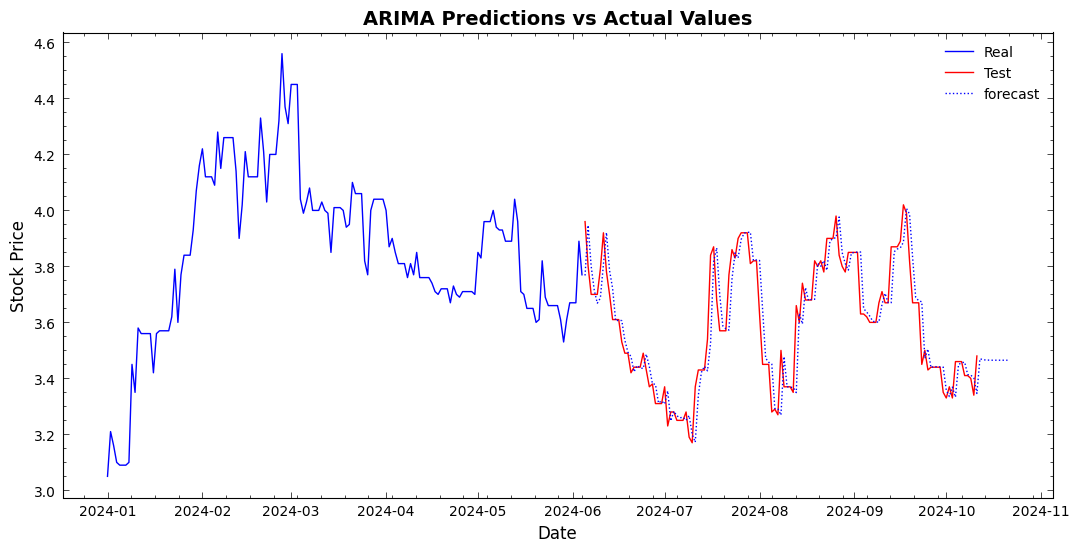

In [ ]:
## Fazendo aqui o plot do t+1
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train[train.index >= '2024-01-01'],linestyle='solid',alpha=1,lw=1, color = 'blue', label='Real')
plt.plot(test,linestyle='solid',alpha=1,lw=1, color='red', label='Test')
plt.plot(forecast_one_step, label='forecast',color='blue', linestyle = 'dotted',alpha=1)

plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
forecast_one_step = forecast_one_step.rename(columns = {'forecast':'ARIMA'}).copy()

df_final = pd.concat([train.rename(columns = {"AVIR":"ARIMA"}), forecast_one_step], axis = 0)

df_final

,ARIMA
2023-01-03,4.810000
2023-01-04,4.780000
2023-01-05,4.690000
2023-01-06,4.700000
2023-01-07,4.700000
...,...
2024-10-17,3.464841
2024-10-18,3.464822
2024-10-19,3.464816
2024-10-20,3.464813


In [ ]:
avir_df = avir_df.asfreq('D', method = 'ffill')

merged_df = pd.merge(df_final, avir_df, how='left', right_index=True, left_index=True)

merged_df.tail(10)

,ARIMA,AVIR
2024-10-12,3.470121,NaN
2024-10-13,3.466678,NaN
2024-10-14,3.465470,NaN
2024-10-15,3.465044,NaN
2024-10-16,3.464894,NaN
2024-10-17,3.464841,NaN
2024-10-18,3.464822,NaN
2024-10-19,3.464816,NaN
2024-10-20,3.464813,NaN
2024-10-21,3.464812,NaN


In [ ]:
merged_df['lag_1'] = merged_df['AVIR'].shift(1)
#merged_df['lag_5'] = merged_df['AVIR'].shift(5)
merged_df['lag_7'] = merged_df['AVIR'].shift(7)
#merged_df['lag_10'] = merged_df['AVIR'].shift(10)
#merged_df['lag_15'] = merged_df['AVIR'].shift(15)
#merged_df['lag_30'] = merged_df['AVIR'].shift(30)


merged_df = merged_df.drop(merged_df.index[:14])

merged_df = merged_df.drop('ARIMA', axis = 1)

merged_df.dropna(subset = 'lag_1', inplace = True)

In [ ]:
## Separação treino test
train_size = int(len(merged_df)*0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

test_df

,AVIR,lag_1,lag_7
2024-06-08,3.70,3.70,3.67
2024-06-09,3.70,3.70,3.67
2024-06-10,3.79,3.70,3.89
2024-06-11,3.92,3.79,3.77
2024-06-12,3.78,3.92,3.96
...,...,...,...
2024-10-08,3.41,3.41,3.33
2024-10-09,3.40,3.41,3.37
2024-10-10,3.34,3.40,3.33
2024-10-11,3.48,3.34,3.46


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('AVIR', axis=1))
test_scaled = scaler.transform(test_df.drop('AVIR', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop('AVIR', axis=1).columns, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop('AVIR', axis=1).columns, index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['AVIR'] = train_df['AVIR']
test_scaled_df['AVIR'] = test_df['AVIR']

forecast_df = test_scaled_df[test_scaled_df['AVIR'].isna()]

test_scaled_df = test_scaled_df.dropna()

# Split the scaled data into Features and Label
y_train = train_scaled_df['AVIR']
X_train = train_scaled_df.drop('AVIR', axis=1)
y_test = test_scaled_df['AVIR']
X_test = test_scaled_df.drop('AVIR', axis=1)

#forecast_df

X_forecast = forecast_df.drop('AVIR', axis=1)
X_forecast

,lag_1,lag_7
2024-10-12,0.300885,0.292035


In [ ]:
## Modelo XGBoost
import xgboost as xgb

In [ ]:
from sklearn.metrics import make_scorer
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)  # MAPE should be minimized

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters, scoring={'R²': 'r2', 'MAPE': mape_scorer}, refit='R²', cv=5)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42}
Best validation score = 0.820497218719472


In [ ]:
reg = xgb.XGBRegressor(
    gamma = 0.02,
    learning_rate = 0.005,
    max_depth = 15,
    n_estimators = 400,
    random_state = 42
)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

## Estatísticas de ajuste:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

Mean Squared Error (MSE): 0.01019176744079916
Mean Absolute Error (MAE): 0.07024149099985759
R2 Score: 0.7828470568933296
Explained Variance Score: 0.7838318211531049
Mean Absolute Percentage Error (MAPE): 1.9551150479854145
Mean Percentage Error (MPE): -0.2650905475933564


In [ ]:
y_forecast = reg.predict(X_forecast)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

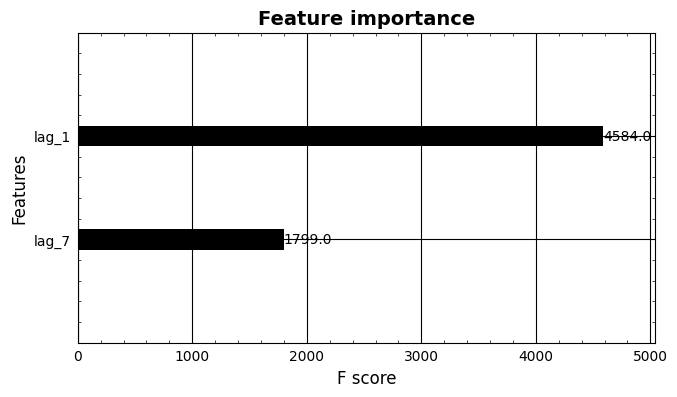

In [ ]:
from xgboost import plot_importance

plot_importance(reg)

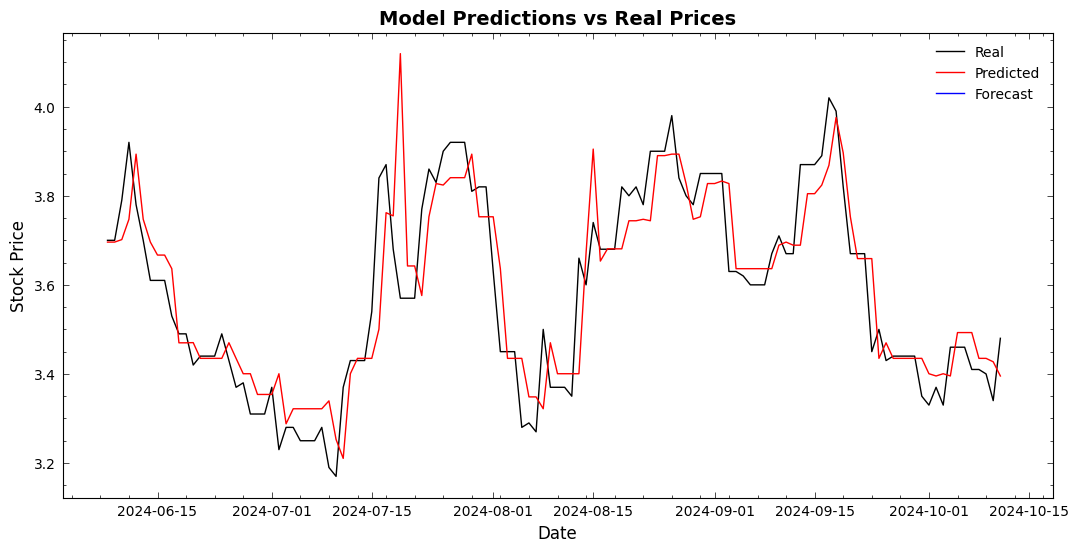

In [ ]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

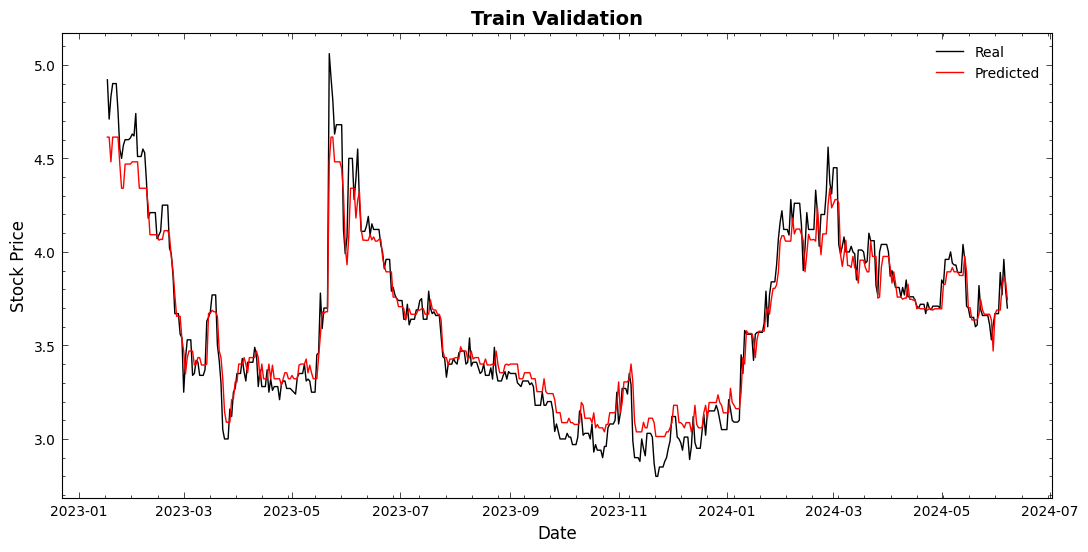

In [ ]:
y_pred_train = reg.predict(X_train)

# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train_scaled_df.index, y_train, label='Real')
plt.plot(train_scaled_df.index, y_pred_train, color='red', label='Predicted')
#plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Train Validation')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()